# Figure 2

This notebook recreates the figure panels included in Figure 2 of Lee et al. 2021. 



### Description of the Data

The data used in this notebook comes from the experiments described in Lee et al. 2021. Specifically, we have the behavioral and activity of a trained deep RL agent performing a evidence accumulation task from Engelhard et al. 2019. 

The dataset includes 5000 trials of the trained agent with frozen weights. 



## Preparing the Data
### Importing required code packages and modules

In [15]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import sys
from scipy.io import loadmat, savemat
import utils.cnnlstm_analysis_utils as utils
import seaborn as sns
from scipy import stats
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

### downloading data

In [6]:
load_prefix = './data/logs/VA_maze/'
with open(load_prefix + '5000t_mosttrain_db.p', 'rb') as f:
     [actions_, rewards_, feats_, terms_, vs_, tow_counts_, episode_lengths]  = pickle.load(f)
f.close()
vs = np.hstack(vs_)
terms = np.hstack(terms_)
rewards = np.hstack(rewards_)
ep_rew = np.array([np.sum(r_trial) for r_trial in rewards_])
ep_tow = np.array([np.max(trial, 0) for trial in tow_counts_])
tow_counts = np.vstack(tow_counts_)



weights = utils.get_params_from_zip(load_prefix + 'rl_model_20800000_steps')
# weights.keys()

w_pol = weights['model/pi/w:0']
b_pol = weights['model/pi/b:0']
w_val = np.squeeze(weights['model/vf/w:0'])
b_val = weights['model/vf/b:0']

trial_info = loadmat(load_prefix + 'trialinfo_db.mat')

trial_info = trial_info['trials']
trial_info.dtype.names
choices = utils.extract_field(trial_info, 'choice')
trial_type = utils.extract_field(trial_info, 'trialType')
raw_ypos = utils.extract_field(trial_info, 'position')[:,1]
cueCombos_ = utils.extract_field(trial_info, 'cueCombo')
cuePos_ = utils.extract_field(trial_info, 'cuePos')
cueOnset_ = utils.extract_field(trial_info, 'cueOnset')
raw_ypos_ = [x[:,1] for x in trial_info['position'][0]]
raw_xpos_ = [x[:,0] for x in trial_info['position'][0]]
raw_vpos_ = [x[:,2] for x in trial_info['position'][0]]
ypos_ = [np.hstack([np.array(x[:-1]), x[-2] * np.ones((7,))]) for x in raw_ypos_]
ypos = np.hstack(ypos_)


### Plotting Parameters

In [7]:
# PLOTTING PARAMS
matplotlib.rcParams.update({'font.size': 15})
matplotlib.rcParams.update({'font.family': 'Arial'})

FONT_BG = 25
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42 # allow text of pdf to be edited in illustrator

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False
from matplotlib.colors import ListedColormap


### Organizing Data

Pulling out the specific data that we will use for figure panels

In [8]:
CUEP_LIM = 140
REWP_LEN_S = -16
REWP_LEN_STP = -5
ypos_cuep = np.squeeze(np.dstack([ypos_t[:CUEP_LIM] for ypos_t in ypos_])[:,:,0])
(ep_towdelt_idx, ep_towdiff_idx) = utils.get_ep_tow_idx(ep_tow)


## Figure 2B: Psychometric Curve of Agent

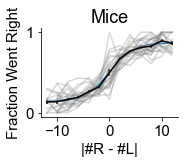

In [13]:
# matlab code: psychometric_neural.m
fitted = loadmat('./data/psycho_neural.mat')['fitted']
ymat = loadmat('./data/psycho_neural.mat')['ymat'].T
x_all = loadmat('./data/psycho_neural.mat')['x_all'].T

fig = plt.figure(figsize=(3, 2.5))
plt.plot(x_all, fitted)
plt.errorbar(x_all, np.nanmean(ymat,1), yerr = np.nanstd(ymat,1)/np.sqrt(np.sum(~np.isnan(ymat),1)), color =  'k')
plt.plot(x_all, ymat, color = 'gray', alpha = 0.3)
plt.title('Mice')
plt.xlabel('|#R - #L|')
plt.ylabel('Fraction Went Right')
plt.tight_layout()

In [10]:
pref_r = []
pref_r_sem = []
for diff_idx in np.flip(ep_towdiff_idx):
    pref_r.append(np.sum(choices[diff_idx] == 'R')/len(choices[diff_idx]))
    pref_r_sem.append(stats.sem(choices[diff_idx] == 'R'))


/Users/sasha/anaconda3/envs/python37/lib/python3.7/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


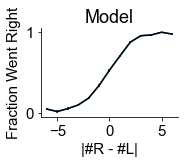

In [11]:
fig = plt.figure(figsize=(3, 2.5))
plt.plot(np.arange(-6,7), pref_r)
plt.errorbar(np.arange(-6,7), pref_r, yerr = pref_r_sem, color =  'k')
plt.title('Model')
plt.xlabel('|#R - #L|')
plt.ylabel('Fraction Went Right')
plt.tight_layout()

## Figure 2D: Scalar value with respect to position 

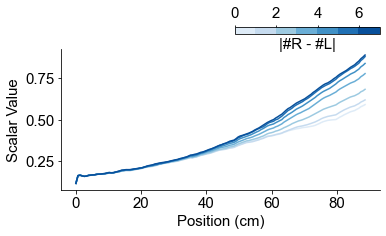

In [12]:
val_cuep = np.vstack([vs_i[:CUEP_LIM] for vs_i in vs_])

fig = plt.figure(figsize = (5.7,3))
gs = gridspec.GridSpec(2,2,height_ratios = [0.05,1])

colors = sns.color_palette("Blues", n_colors = 7)
ax_sum = plt.subplot(gs[1,:])
for ep_towdelt in np.arange(len(ep_towdelt_idx)):
    rew_difficulty = np.sort(list(set(np.where(ep_rew == 1)[0]) & set(ep_towdelt_idx[ep_towdelt])))
    ax_sum.plot(ypos_cuep, np.nanmean(val_cuep[rew_difficulty,:],0)
                                , color = colors[ep_towdelt],  label = 'delt:' + str(ep_towdelt));
ax_sum.set_xlabel('Position (cm)')
ax_sum.set_ylabel('Scalar Value')


# code for showing a colorbar
cmap = ListedColormap(colors.as_hex())
bounds = np.arange(8)
norm = matplotlib.colors.BoundaryNorm(boundaries = bounds, ncolors = 7)


lax = plt.subplot(gs[0,1])
dummy_plot = lax.scatter(bounds, bounds, c = bounds, cmap = cmap, norm = norm)
lax.cla()
cbar = plt.colorbar(dummy_plot, orientation='horizontal',cax = lax, ticks = [0, 2, 4, 6])
cbar.ax.tick_params(length = 2.5)

cbar.ax.xaxis.set_ticks_position("top")
cbar.set_label('|#R - #L|')
